In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from functools import reduce
import pylab as plt

from scipy import stats

from importlib import reload
import itertools
from itertools import count

import sys

In [2]:
def plot_context():
    sns.set_context("talk", rc={"font.size":18,"axes.titlesize":18,"axes.labelsize":16,"font_scale":0.9})
image_path = '/scratch/c.c21013066/images/ukbiobank/accelerometer'
data_path = '/scratch/c.c21013066/data/ukbiobank/sample/withGP'
acc_path = '/scratch/c.c21013066/data/ukbiobank/phenotypes/accelerometer'

In [86]:
# load acc merged file
acc = pd.read_csv(f'{acc_path}/matched_all_HCnoOsteo_genebloodrisk.csv',index_col=0)
#acc['Healthy_age'] = np.nan
#acc.loc[acc['diagnosis']=='Healthy','Healthy_age'] = 999
acc = acc.drop(columns='Unnamed: 0')
# or load HC file
#acc = pd.read_csv(f'{acc_path}/allHCnoOsteo.csv').set_index('eid')
#acc['Healthy'] = 1
# for each prodromal sign load who has it and merge info with acc
prodromal = ['UrinaryIncontinence','Constipation','ErectileDysfunction','Anxiety','RBD','Hyposmia','OrthostaticHypotension']
prodromal_all = ['UrinaryIncontinence','Constipation','ErectileDysfunction','Anxiety','RBD','Hyposmia','OrthostaticHypotension',
                'Depression']
sizes = pd.DataFrame(index=prodromal,columns=['N_cases','percent_UKBB'])
for p in prodromal_all:
    cases = pd.read_csv(f'{data_path}/{p}.csv',index_col=0)
    cases[p] = 1
    sizes.loc[p,'N_cases'] = cases.shape[0]
    sizes.loc[p,'percent_UKBB'] = 100/504736*sizes.loc[p,'N_cases']
    print(cases.shape)
    print(len(np.intersect1d(acc.index,cases.index)))
    acc = pd.merge(acc,cases[[f'{p}_age',p]],right_index=True,left_index=True,how='left',suffixes=['_diag',''])
    acc.loc[acc[p].isna(),p] = 0

/scratch/c.c21013066/docker/envs/py38R/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3155: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(16816, 48)
1407
(43249, 48)
3103
(14820, 48)
869
(47604, 48)
4740
(305, 48)
27
(708, 48)
48
(6852, 48)
451
(59037, 48)
9586


In [87]:
# add PD age
PD = pd.read_csv(f'{data_path}/noOsteo/ParkinsonDisease.csv').set_index('eid')
PD = PD.rename(columns={'ParkinsonDisease_age':'PD_age'})
acc = pd.merge(acc,PD['PD_age'],right_index=True,left_index=True,how='left')

In [64]:
diseases = ['AllCauseDementia','AlzheimerDisease','AllCauseParkinsonism','ParkinsonDisease','Dystonia','Osteoarthritis',"Healthy"]
diseases_all = ['AllCauseDementia','AlzheimerDisease','AllCauseParkinsonism','ParkinsonDisease','Dystonia','Osteoarthritis','Depression','Healthy']

In [88]:
for d in diseases_all:
    parkin = acc[acc['diagnosis']==d]
    if parkin.shape[0] > 0:
        print(d)
        for p in prodromal_all:
            parkin[f'{p}_prodromal'] = (parkin[f'{p}_age'] <= parkin[f'{d}_age']).astype(int)
            parkin.loc[np.logical_and(parkin[p]==1,parkin[d]==0),f'{p}_prodromal'] = 1
            parkin.loc[parkin[p]==0,f'{p}_prodromal'] = np.nan
            parkin[f'{p}_beforeacc'] = (parkin[f'{p}_age'] <= parkin['accelerometry_age']).astype(int)
            parkin.loc[parkin[p]!=1,f'{p}_beforeacc'] = 0
            parkin[f'{p}_beforePD'] = (parkin[f'{p}_age'] <= parkin['PD_age']).astype(int)
            parkin.loc[np.logical_and(parkin[p]==1,parkin['PD']==0),f'{p}_beforePD'] = 1
            parkin.loc[parkin[p]==0,f'{p}_beforePD'] = 0
            parkin[f'{p}_timeto{d}'] = parkin[f'{d}_age'] - parkin[f'{p}_age']
            parkin[f'{p}_status'] = parkin[f'{p}_prodromal'].replace([0,1,np.nan],['Diseased','Prodromal','Healthy'])
            acc.loc[np.logical_and(acc.index.isin(parkin.index),acc['diagnosis']==d),f'{p}_prodromal'] = parkin[f'{p}_prodromal']
            acc.loc[np.logical_and(acc.index.isin(parkin.index),acc['diagnosis']==d),f'{p}_beforeacc'] = parkin[f'{p}_beforeacc']
            acc.loc[np.logical_and(acc.index.isin(parkin.index),acc['diagnosis']==d),f'{p}_beforePD'] = parkin[f'{p}_beforePD']

AllCauseDementia


<ipython-input-88-3d92d8d9eba7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parkin[f'{p}_prodromal'] = (parkin[f'{p}_age'] <= parkin[f'{d}_age']).astype(int)
/scratch/c.c21013066/docker/envs/py38R/lib/python3.8/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/scratch/c.c21013066/docker/envs/py38R/lib/python3.8/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

AlzheimerDisease
AllCauseParkinsonism


<ipython-input-88-3d92d8d9eba7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parkin[f'{p}_prodromal'] = (parkin[f'{p}_age'] <= parkin[f'{d}_age']).astype(int)
/scratch/c.c21013066/docker/envs/py38R/lib/python3.8/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/scratch/c.c21013066/docker/envs/py38R/lib/python3.8/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

ParkinsonDisease
Dystonia


<ipython-input-88-3d92d8d9eba7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parkin[f'{p}_prodromal'] = (parkin[f'{p}_age'] <= parkin[f'{d}_age']).astype(int)
/scratch/c.c21013066/docker/envs/py38R/lib/python3.8/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/scratch/c.c21013066/docker/envs/py38R/lib/python3.8/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

Osteoarthritis


<ipython-input-88-3d92d8d9eba7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parkin[f'{p}_prodromal'] = (parkin[f'{p}_age'] <= parkin[f'{d}_age']).astype(int)
/scratch/c.c21013066/docker/envs/py38R/lib/python3.8/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/scratch/c.c21013066/docker/envs/py38R/lib/python3.8/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

Depression


/scratch/c.c21013066/docker/envs/py38R/lib/python3.8/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
<ipython-input-88-3d92d8d9eba7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parkin[f'{p}_beforePD'] = (parkin[f'{p}_age'] <= parkin['PD_age']).astype(int)
/scratch/c.c21013066/docker/envs/py38R/lib/python3.8/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

In [60]:
prod = pd.DataFrame(index=pd.MultiIndex.from_product([diseases,prodromal_all],names=['disease','prodromal_sign']),
                    columns=['N_prodromal','N_healthy','N_diseased','percent_cases','percent_prodromal',
                                                 'time_to_diag_prod_mean',
                                                 'time_to_diag_prod_std'])
for d in diseases:
    parkin = acc[np.logical_and(acc['diagnosis']==d,acc['Status']!='Healthy')]
    #if parkin.shape[0] > 0:
    for p in prodromal_all:
        parkin[f'{p}_prodromal'] = (parkin[f'{p}_age'] <= parkin[f'{d}_age']).astype(int)
        parkin.loc[np.logical_and(parkin[p]==1,parkin[d]==0),f'{p}_prodromal'] = 1
        parkin.loc[parkin[p]==0,f'{p}_prodromal'] = np.nan
        parkin[f'{p}_beforeacc'] = (parkin[f'{p}_age'] <= parkin['accelerometry_age']).astype(int)
        parkin.loc[parkin[p]!=1,f'{p}_beforeacc'] = np.nan
        parkin[f'{p}_beforePD'] = (parkin[f'{p}_age'] <= parkin['PD_age']).astype(int)
        parkin.loc[np.logical_and(parkin[p]==1,parkin['PD']==0),f'{p}_beforePD'] = 1
        parkin.loc[parkin[p]==0,f'{p}_beforePD'] = 0
        parkin[f'{p}_timeto{d}'] = parkin[f'{d}_age'] - parkin[f'{p}_age']
        parkin[f'{p}_status'] = parkin[f'{p}_prodromal'].replace([0,1,np.nan],['Diseased','Prodromal','Healthy'])
        prod.loc[(d,p),'N_prodromal'] = parkin[parkin[f'{p}_status']=='Prodromal'].shape[0]
        prod.loc[(d,p),'N_diseased'] = parkin[parkin[f'{p}_status']=='Diseased'].shape[0]
        prod.loc[(d,p),'N_healthy'] = parkin[parkin[f'{p}_status']=='Healthy'].shape[0]
        prod.loc[(d,p),'percent_cases'] = 100/parkin.shape[0] * (prod.loc[(d,p),'N_prodromal'] + prod.loc[(d,p),'N_diseased'])
        prod.loc[(d,p),'percent_prodromal'] = 100/parkin.shape[0] * (prod.loc[(d,p),'N_prodromal'])
        prod.loc[(d,p),f'time_to_diag_prod_mean'] = parkin.loc[parkin[f'{p}_status']=='Prodromal',f'{p}_timeto{d}'].mean()
        prod.loc[(d,p),f'time_to_diag_prod_std'] = parkin.loc[parkin[f'{p}_status']=='Prodromal',f'{p}_timeto{d}'].std()

<ipython-input-60-8ace3bd789c4>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parkin[f'{p}_prodromal'] = (parkin[f'{p}_age'] <= parkin[f'{d}_age']).astype(int)
/scratch/c.c21013066/docker/envs/py38R/lib/python3.8/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/scratch/c.c21013066/docker/envs/py38R/lib/python3.8/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

In [65]:
# test if prodromal sign more frequent in one disease than PD
chi = pd.DataFrame(index=pd.MultiIndex.from_product([diseases,prodromal_all],names=['disease','prodromal_sign']),
                   columns=['chi2','p','dof','ex'])
for d in diseases_all:
    #if d !='ParkinsonDisease' and d != 'AllCauseParkinsonism':
        for p in prodromal_all:
            cont = pd.DataFrame(index=[d,'PD'],columns=['Healthy',p])
            cont.loc[d,'Healthy'] = prod.loc[(d,p),'N_healthy']
            cont.loc[d,p] = prod.loc[(d,p),'N_prodromal']
            cont.loc['PD','Healthy'] = prod.loc[('ParkinsonDisease',p),'N_healthy']
            cont.loc['PD',p] = prod.loc[('ParkinsonDisease',p),'N_prodromal']
            try:
                chi.loc[(d,p),:] = stats.chi2_contingency(cont)
            except:
                print('zero element for ',d,' ',p)
                print(cont)
chi = chi.dropna(axis='rows',how='all')

KeyError: ('Depression', 'UrinaryIncontinence')

<AxesSubplot:xlabel='prodromal_sign', ylabel='disease'>

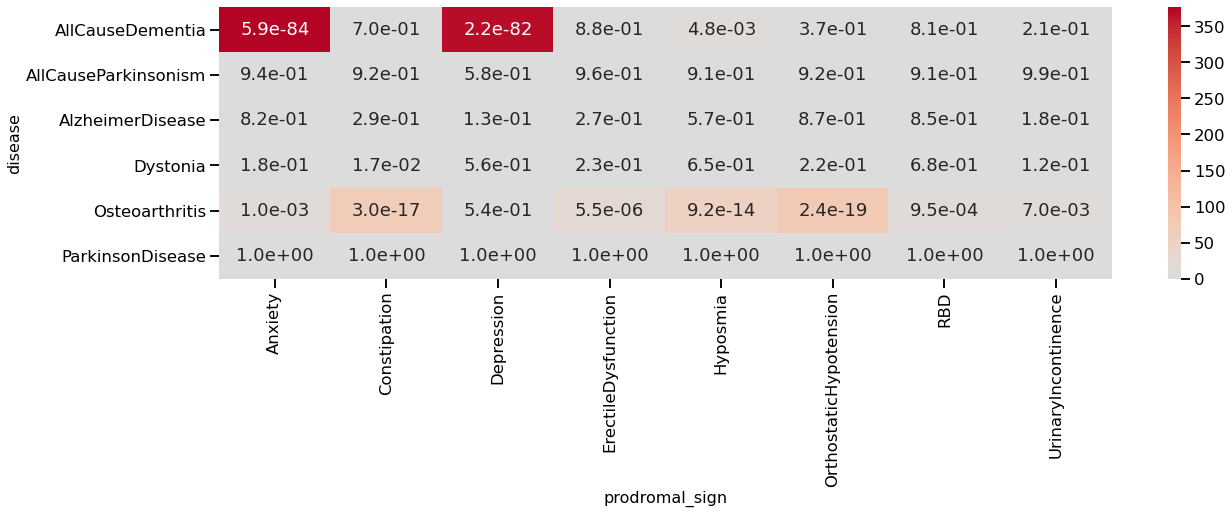

In [62]:
fig = plt.figure(figsize=(20,5))
plot_context()
sns.heatmap(chi['chi2'].unstack().astype(float),annot=chi['p'].unstack(),cmap='coolwarm',center=0,fmt='.1e')

In [89]:
# do PD more often have multiple prodromal signs?
prod_col = [f'{p}_beforePD' for p in prodromal]
acc['N_signs'] = acc[prodromal_all].sum(axis=1)
acc['N_prodromalsigns'] = acc[prod_col].sum(axis=1)

<AxesSubplot:xlabel='N_prodromalsigns', ylabel='diagnosis'>

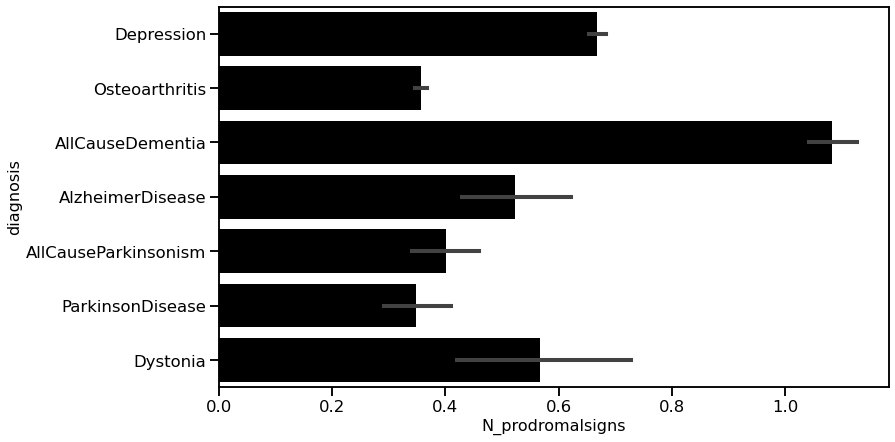

In [67]:
fig = plt.figure(figsize=(12,7))
plot_context()
sns.barplot(data=acc[acc['Status']!='Healthy'],y='diagnosis',x='N_prodromalsigns',color='k')

In [ ]:
prod

In [68]:
acc[np.logical_and(acc['diagnosis']=='ParkinsonDisease',acc['RBD']==1)].filter(regex='_age')

,visit_age,AllCauseDementia_age,accelerometry_age,AllCauseParkinsonism_age,AlzheimerDisease_age,MultipleSystemAtrophy_age,ProgressiveSupranuclearPalsy_age,FrontoTemporalDementia_age,VascularDementia_age,Dystonia_age,...,Healthy_age,UrinaryIncontinence_age,Constipation_age,ErectileDysfunction_age,Anxiety_age,RBD_age,Hyposmia_age,OrthostaticHypotension_age,Depression_age,PD_age
eid,,,,,,,,,,,,,,,,,,,,,
1488239,60.285974,NaN,65.174279,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,67.273113,NaN,NaN,NaN,67.273113
1920547,49.829908,NaN,55.232939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,61.211387,58.807505,NaN,59.601498,60.592620,NaN,NaN,NaN,45.881846
3420700,48.477381,NaN,54.348595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,52.398064,NaN,NaN,NaN,48.000000
3707110,66.517451,NaN,71.323618,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,71.935769,66.657084,NaN,70.594194,NaN,NaN,NaN,63.880846
5015084,60.184672,NaN,66.786906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,70.848820,NaN,NaN,NaN,70.848820


In [35]:
dfs = pd.read_csv('/scratch/c.c21013066/data/ukbiobank/phenotypes/accelerometer/matched_all_HCnoOsteo_prodromalsigns.csv',index_col=0)

In [90]:
acc.to_csv(f'{acc_path}/matched_all_HCnoOsteo_genebloodrisk_prodromalsigns.csv')